### Regridding data to climate grid scale
[18-09-19]

In [17]:
# Libraries
%load_ext autoreload
%autoreload

import numpy as np
import iris
import iris.coord_categorisation
import pandas as pd

import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Loading in the data
dir = '../data/'
files = {'cropland'     :'states.TRENDYv8.proc.crop.n96e.nc',
         'fract_agr'    :'states.TRENDYv8.proc.frac_agr.n96e.nc',
         'pasture'      :'states.TRENDYv8.proc.pastr.n96e.nc'}


input_data = {}

for key, f in files.items():
    dat = iris.load_cube(dir + f, 'area_fraction')
    input_data[key] = dat

Need to add in the dimension coordinates for latitude and longitude, so we're going to load in a UKESM file to pinch the lat and lon dim coords from there

In [19]:
template = iris.load_cube(dir + 'qrparm.veg.frac.nc')

# Taking the array of the coordinates
lat = template.coord('latitude').points
lon = template.coord('longitude').points

Setting up the coordinates

In [20]:
# Dim coord for latitude (index: 1)
coord_lat = iris.coords.DimCoord(lat, standard_name='latitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='latitude',
                                 units='degrees')

# Dim coord for longitude (index: 2)
coord_lon = iris.coords.DimCoord(lon, standard_name='longitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='longitude',
                                 units='degrees')

Loading in the mask to use for regridding

In [21]:
dir_mask = '../data/climate/'
file = 'climate_mask.nc'

mask = iris.load_cube(dir_mask + file)

### Regridding the data

In [22]:
regrid_data = {}
for key in input_data.keys():
    
    # Adding dimension coordinates to data
    try:        
        mask.coord('latitude').guess_bounds()
        mask.coord('longitude').guess_bounds()
    except:
        pass
    
    try:
        input_data[key].add_dim_coord(coord_lat, 1)
        input_data[key].add_dim_coord(coord_lon, 2)
    except:
        pass
    try:
        input_data[key].coord('longitude').guess_bounds()
        input_data[key].coord('latitude').guess_bounds()
    except:
        pass
    # Regridding the data
    regrid_data[key] = input_data[key].regrid(mask, iris.analysis.AreaWeighted())

Compare to original files

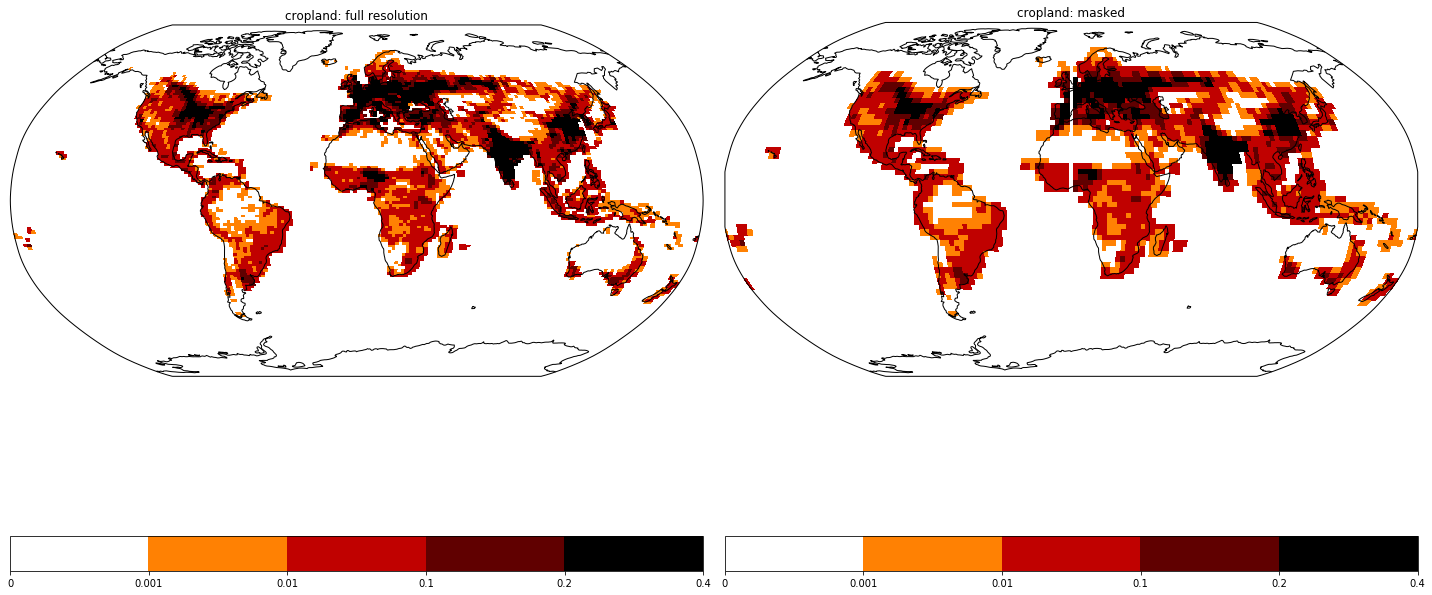

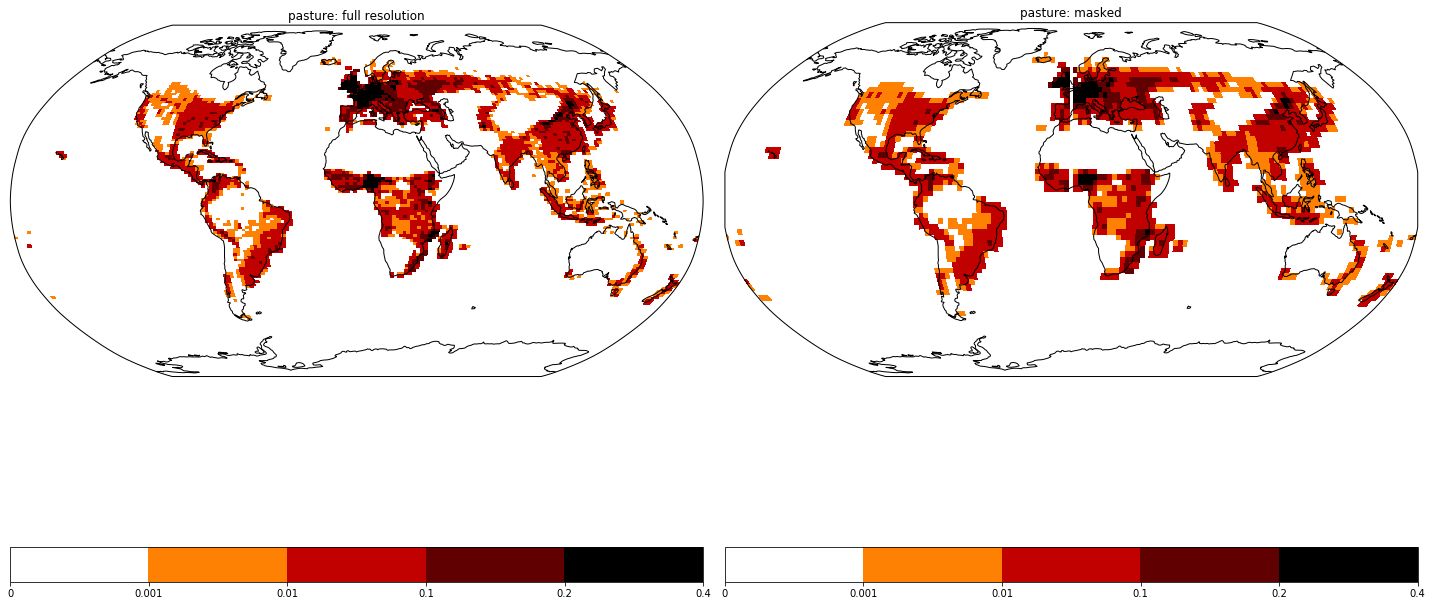

In [23]:
plt.rcParams['figure.figsize'] = [20, 45]

i = 1

for key in regrid_data.keys():
    if key is not "fract_agr":
    #    plt.subplot(1, 2, 1)
        dat1 = input_data[key].collapsed('time', iris.analysis.MEAN)
        plot_lonely_cube(dat1, len(regrid_data.keys()), 2, i, cmap = 'gist_heat_r', levels = [0, 0.001, 0.01, 0.1, 0.2, 0.4])
        plt.title('%s: full resolution' %key)
        i = i + 1

    #    plt.subplot(1, 2, 2)
        dat2 = regrid_data[key].collapsed('time', iris.analysis.MEAN)
        plot_lonely_cube(dat2, len(regrid_data.keys()), 2, i, cmap = 'gist_heat_r', levels = [0, 0.001, 0.01, 0.1, 0.2, 0.4])
        plt.title('%s: masked' %key)
        plt.show()
        i = i + 1

### Interpolate post 2000 to monthly

Template from climate data

In [24]:
dir_temp = '../outputs/climate/from_2001/'
file_temp = 'air2001-2019.nc'
temp = iris.load_cube(dir_temp + file_temp)

In [34]:
from pdb import set_trace as browser
post_2001 = {}
j = 0
for key in regrid_data.keys():
    dat = temp.copy()
    print(key)
    # We need to put data directly into post_2001.data so we have to give it a frame first
    post_2001[key] = temp.copy()
    for mnth in range(dat.data.shape[0]):
        year = np.int(np.floor(mnth/12.0))
        year_f = min([regrid_data[key].data.shape[0] - 1, year+ 301])
        m = np.int(mnth - 12 * year)
        dat.data[mnth] = regrid_data[key].data[year_f]*(m/12) + regrid_data[key].data[year_f]*((12-m)/12)
        
        print('variable', key, 'year: ', year+2001, 'and j: ', mnth, 'and m: ', m)
        
    post_2001[key].data = dat.data

cropland
301
variable cropland year:  2001 and j:  0 and m:  0
301
variable cropland year:  2001 and j:  1 and m:  1
301
variable cropland year:  2001 and j:  2 and m:  2
301
variable cropland year:  2001 and j:  3 and m:  3
301
variable cropland year:  2001 and j:  4 and m:  4
301
variable cropland year:  2001 and j:  5 and m:  5
301
variable cropland year:  2001 and j:  6 and m:  6
301
variable cropland year:  2001 and j:  7 and m:  7
301
variable cropland year:  2001 and j:  8 and m:  8
301
variable cropland year:  2001 and j:  9 and m:  9
301
variable cropland year:  2001 and j:  10 and m:  10
301
variable cropland year:  2001 and j:  11 and m:  11
302
variable cropland year:  2002 and j:  12 and m:  0
302
variable cropland year:  2002 and j:  13 and m:  1
302
variable cropland year:  2002 and j:  14 and m:  2
302
variable cropland year:  2002 and j:  15 and m:  3
302
variable cropland year:  2002 and j:  16 and m:  4
302
variable cropland year:  2002 and j:  17 and m:  5
302
varia

301
variable fract_agr year:  2001 and j:  0 and m:  0
301
variable fract_agr year:  2001 and j:  1 and m:  1
301
variable fract_agr year:  2001 and j:  2 and m:  2
301
variable fract_agr year:  2001 and j:  3 and m:  3
301
variable fract_agr year:  2001 and j:  4 and m:  4
301
variable fract_agr year:  2001 and j:  5 and m:  5
301
variable fract_agr year:  2001 and j:  6 and m:  6
301
variable fract_agr year:  2001 and j:  7 and m:  7
301
variable fract_agr year:  2001 and j:  8 and m:  8
301
variable fract_agr year:  2001 and j:  9 and m:  9
301
variable fract_agr year:  2001 and j:  10 and m:  10
301
variable fract_agr year:  2001 and j:  11 and m:  11
302
variable fract_agr year:  2002 and j:  12 and m:  0
302
variable fract_agr year:  2002 and j:  13 and m:  1
302
variable fract_agr year:  2002 and j:  14 and m:  2
302
variable fract_agr year:  2002 and j:  15 and m:  3
302
variable fract_agr year:  2002 and j:  16 and m:  4
302
variable fract_agr year:  2002 and j:  17 and m:  5


variable fract_agr year:  2014 and j:  160 and m:  4
314
variable fract_agr year:  2014 and j:  161 and m:  5
314
variable fract_agr year:  2014 and j:  162 and m:  6
314
variable fract_agr year:  2014 and j:  163 and m:  7
314
variable fract_agr year:  2014 and j:  164 and m:  8
314
variable fract_agr year:  2014 and j:  165 and m:  9
314
variable fract_agr year:  2014 and j:  166 and m:  10
314
variable fract_agr year:  2014 and j:  167 and m:  11
315
variable fract_agr year:  2015 and j:  168 and m:  0
315
variable fract_agr year:  2015 and j:  169 and m:  1
315
variable fract_agr year:  2015 and j:  170 and m:  2
315
variable fract_agr year:  2015 and j:  171 and m:  3
315
variable fract_agr year:  2015 and j:  172 and m:  4
315
variable fract_agr year:  2015 and j:  173 and m:  5
315
variable fract_agr year:  2015 and j:  174 and m:  6
315
variable fract_agr year:  2015 and j:  175 and m:  7
315
variable fract_agr year:  2015 and j:  176 and m:  8
315
variable fract_agr year:  201

variable pasture year:  2007 and j:  82 and m:  10
307
variable pasture year:  2007 and j:  83 and m:  11
308
variable pasture year:  2008 and j:  84 and m:  0
308
variable pasture year:  2008 and j:  85 and m:  1
308
variable pasture year:  2008 and j:  86 and m:  2
308
variable pasture year:  2008 and j:  87 and m:  3
308
variable pasture year:  2008 and j:  88 and m:  4
308
variable pasture year:  2008 and j:  89 and m:  5
308
variable pasture year:  2008 and j:  90 and m:  6
308
variable pasture year:  2008 and j:  91 and m:  7
308
variable pasture year:  2008 and j:  92 and m:  8
308
variable pasture year:  2008 and j:  93 and m:  9
308
variable pasture year:  2008 and j:  94 and m:  10
308
variable pasture year:  2008 and j:  95 and m:  11
309
variable pasture year:  2009 and j:  96 and m:  0
309
variable pasture year:  2009 and j:  97 and m:  1
309
variable pasture year:  2009 and j:  98 and m:  2
309
variable pasture year:  2009 and j:  99 and m:  3
309
variable pasture year:  

### Save the outputs

In [33]:
for key, dat in post_2001.items():
    new_file_names = key + "2001-2019.nc"
    out = '../outputs/human/from_2001/' + new_file_names
    print(new_file_names)
    iris.save(dat, out)

cropland2001-2019.nc
fract_agr2001-2019.nc
pasture2001-2019.nc
